In [1]:
model_name = "Original_Pretrained_R2plus1DMotionSegNet.pth"

# model_name = "dropout_v2_0_25_R2plus1DMotionSegNet.pth"
# model_name = "dropout_v3_0_10_R2plus1DMotionSegNet.pth"

In [2]:
import os
os.chdir("../..")
print(os.getcwd())

%config Completer.use_jedi = False

import SimpleITK as itk
from LabelFusion.wrapper import fuse_images

import echonet
from echonet.datasets import Echo

import torch.nn.functional as F
from torchvision.models.video import r2plus1d_18
from torch.utils.data import Dataset, DataLoader, Subset
from multiprocessing import cpu_count

from src.utils.torch_utils import TransformDataset, torch_collate
from src.utils.echo_utils import get2dPucks
from src.utils.camus_validate import cleanupSegmentation
from src.transform_utils import generate_2dmotion_field
from src.visualization_utils import categorical_dice
from src.loss_functions import huber_loss, convert_to_1hot, convert_to_1hot_tensor
from src.echonet_dataset import EDESpairs, EchoNetDynamicDataset

from src.model.R2plus1D_18_MotionNet import R2plus1D_18_MotionNet

# v2 dropout (in place before motion heads, forgot to define in forward pass function, but still saw diff, weird.)
from src.model.dropout_v2_0_00_R2plus1D_18_MotionNet import dropout_v2_0_00_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_10_R2plus1D_18_MotionNet import dropout_v2_0_10_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_25_R2plus1D_18_MotionNet import dropout_v2_0_25_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_50_R2plus1D_18_MotionNet import dropout_v2_0_50_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_75_R2plus1D_18_MotionNet import dropout_v2_0_75_R2plus1D_18_MotionNet
# v3 dropout (one dropout layer defined in forward pass func, this should've been the correct way to do it.)
from src.model.dropout_v3_0_00_R2plus1D_18_MotionNet import dropout_v3_0_00_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_10_R2plus1D_18_MotionNet import dropout_v3_0_10_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_25_R2plus1D_18_MotionNet import dropout_v3_0_25_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_50_R2plus1D_18_MotionNet import dropout_v3_0_50_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_75_R2plus1D_18_MotionNet import dropout_v3_0_75_R2plus1D_18_MotionNet
# v4 dropout (4 dropout layers in different places in the forward func, I'm going to guess more "generalizable")
from src.model.dropout_v4_0_00_R2plus1D_18_MotionNet import dropout_v4_0_00_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_10_R2plus1D_18_MotionNet import dropout_v4_0_10_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_25_R2plus1D_18_MotionNet import dropout_v4_0_25_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_50_R2plus1D_18_MotionNet import dropout_v4_0_50_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_75_R2plus1D_18_MotionNet import dropout_v4_0_75_R2plus1D_18_MotionNet

# for finding lv seg borders
import cv2 as cv

# for storing vector snapshots
import copy

# from src.visualization_utils import categorical_dice

import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import random
import pickle
import time

tic, toc = (time.time, time.time)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


batch_size = 4
num_workers = max(4, cpu_count()//2)


def worker_init_fn_valid(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    

def worker_init_fn(worker_id):
    # See here: https://pytorch.org/docs/stable/notes/randomness.html#dataloader
    # and the original post of the problem: https://github.com/pytorch/pytorch/issues/5059#issuecomment-817373837
    worker_seed = torch.initial_seed() % 2 ** 32
    print(f'worker_seed: {worker_seed}')
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    

def permuter(list1, list2):
    for i1 in list1:
        for i2 in list2:
            yield (i1, i2)
            

param_trainLoader = {'collate_fn': torch_collate,
                     'batch_size': batch_size,
                     'num_workers': max(4, cpu_count()//2),
                     'worker_init_fn': worker_init_fn}

param_testLoader = {'collate_fn': torch_collate,
                    'batch_size': batch_size,
                    'shuffle': False,
                    'num_workers': max(4, cpu_count()//2),
                    'worker_init_fn': worker_init_fn}

paramLoader = {'train': param_trainLoader,
               'valid': param_testLoader,
               'test':  param_testLoader}


with open("fold_indexes/stanford_valid_sampled_indices", "rb") as infile:
    valid_mask = pickle.load(infile)
infile.close()

# full_dataset = EchoNetDynamicDataset(split='val', clip_length="full", subset_indices=valid_mask, period=1)
test_dataset = EchoNetDynamicDataset(split='test', clip_length="full", raise_for_es_ed=False, period=1)
# random_test_dataset = EchoNetDynamicDataset(split='test', clip_length=32, raise_for_es_ed=True, period=1)

/home/wang/workspace/JupyterNoteBooksAll/fully-automated-multi-heartbeat-echocardiography-video-segmentation-and-motion-tracking


100%|██████████| 16/16 [00:01<00:00, 14.36it/s]


In [3]:
model_save_path = f"save_models/{model_name}"
    
if model_name == 'Original_Pretrained_R2plus1DMotionSegNet.pth':
    model_template_obj = R2plus1D_18_MotionNet()
elif model_name == 'dropout_v2_0_00_R2plus1DMotionSegNet.pth':
    model_template_obj = dropout_v2_0_00_R2plus1D_18_MotionNet()
elif model_name == 'dropout_v2_0_10_R2plus1DMotionSegNet.pth':
    model_template_obj = dropout_v2_0_10_R2plus1D_18_MotionNet()
elif model_name == 'dropout_v2_0_25_R2plus1DMotionSegNet.pth':
    model_template_obj = dropout_v2_0_25_R2plus1D_18_MotionNet()


elif model_name == "dropout_v3_0_00_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v3_0_00_R2plus1D_18_MotionNet()
elif model_name == "dropout_v3_0_10_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v3_0_10_R2plus1D_18_MotionNet()
elif model_name == "dropout_v3_0_25_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v3_0_25_R2plus1D_18_MotionNet()
elif model_name == "dropout_v4_0_00_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v4_0_00_R2plus1D_18_MotionNet()
elif model_name == "dropout_v4_0_10_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v4_0_10_R2plus1D_18_MotionNet()
elif model_name == "dropout_v4_0_25_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v4_0_25_R2plus1D_18_MotionNet()


model = torch.nn.DataParallel(model_template_obj)

model.to("cuda")
torch.cuda.empty_cache()
model.load_state_dict(torch.load(model_save_path)["model"])
print(f'{model_name} has {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters.')
model.eval();

Original_Pretrained_R2plus1DMotionSegNet.pth has 31575731 parameters.


In [4]:
from src.strain import *

In [5]:
%matplotlib widget

In [6]:
N = 3
test_pat_index = 0

curr_clip_segmentations, curr_clip_motions, delta_ed_es, clip_index, ed_label, es_label = get_seg_and_warp_data(model = model,
                                                                                            test_dataset = test_dataset,
                                                                                            test_pat_index = test_pat_index)
    
ed_raw_seg_out = curr_clip_segmentations[:,0,...]

ed_one_hot_seg_out = one_hot(ed_raw_seg_out)

In [7]:
for i in range(delta_ed_es):
    print( np.max(curr_clip_motions[0][i][40][50]))

0.06205837428569794
0.05663377791643143
0.04309462755918503
0.03696459159255028
0.029834432527422905
0.025730900466442108
0.010067879222333431
-0.06245971471071243
-0.15417933464050293
-0.1390385776758194
-0.1266656070947647
-0.10486695915460587
-0.08403713256120682
-0.07925579696893692
-0.07516179233789444
-0.06375908851623535


In [8]:
I = ed_one_hot_seg_out
# I = ed_label

I_regional_point_sets = image_to_regional_point_sets(I)

/home/wang/workspace/JupyterNoteBooksAll/fully-automated-multi-heartbeat-echocardiography-video-segmentation-and-motion-tracking/src/strain.py:1156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  I_regional_point_sets = np.array(I_regional_point_sets)


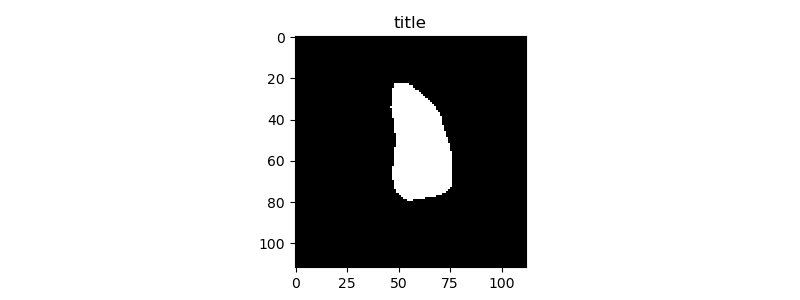

In [9]:
vis_single(I, cmap='gray')

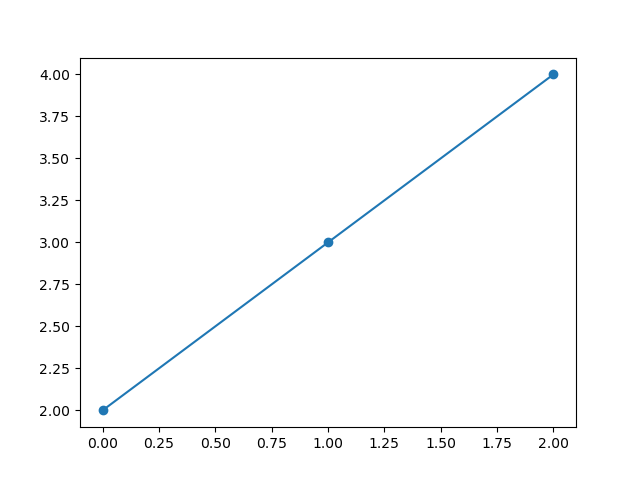

Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 1.75, 'type': 'set_device_pixel_ratio'}


In [10]:
%matplotlib widget

from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax.plot([0,1,2], [2,3,4] ,"o-")

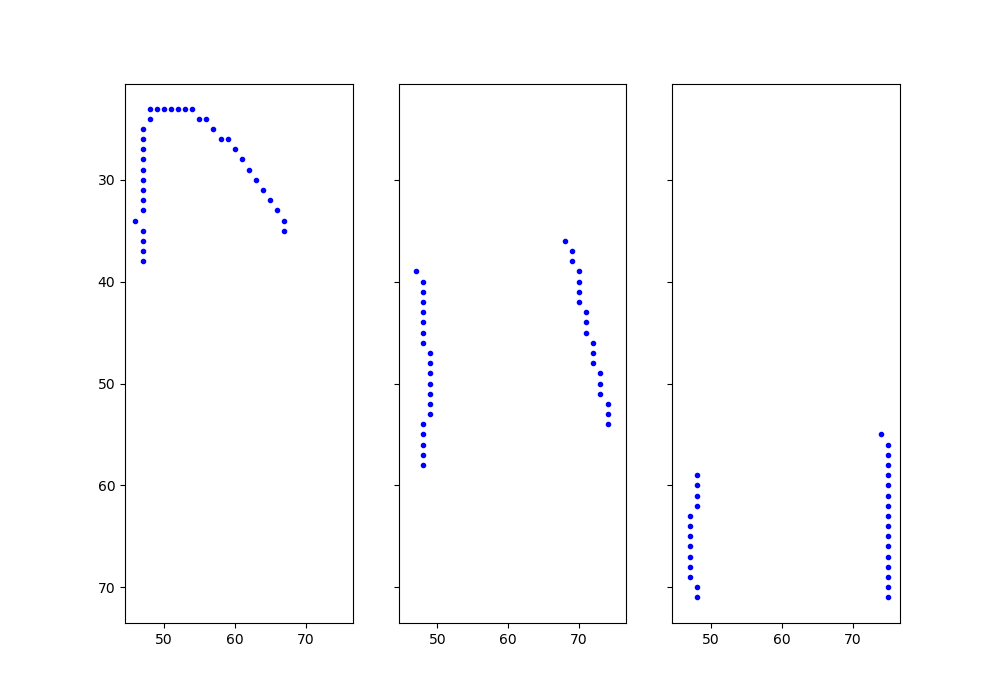

In [12]:
vis_three_point_sets(I_regional_point_sets)

In [11]:
I_regional_point_sets.shape

(3,)

In [12]:
I_regional_point_sets[0].shape

(36, 2)

In [13]:
def vis_single_point_set_from_vectors(ps_vectors):
    ''' ps_vectors - (N, ) np array storing vectors with format (x, y, delta_x, delta_y) '''
    f, ax = plt.subplots(1, 1, figsize=(4, 5))
    x = []
    y = []
    for v in ps_vectors:
        x.append(v.tail_x)
        y.append(v.tail_y)
    ax.scatter(x, y, marker='.', color='b')
    ax.invert_yaxis()

In [14]:
def vis_single_point_set(ps):
    ''' ps - (N, 2) stored in (x,y)'''
    f, ax = plt.subplots(1, 1, figsize=(4, 5))
    ax.scatter(ps[:, 0], ps[:, 1], marker='.', color='b')
    ax.invert_yaxis()

In [15]:
def image_to_whole_point_set(I):
    '''
    I - (112, 112) whole image segmentation
    points - (N, 2) stored in x, y
    '''
    I = give_boundary_no_basal_plane(I)
    points = []
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            if I[i][j] == 1:
                points.append(np.array([j, i]))
    return np.array(points)

## break

In [16]:
def convert_point_set_ij_into_xy(ps_ij):
    ''' 
    converts a point set of shape (M, 2) of points in the (i,j) format into 
    point set of shape (M, 2) of points in the (x,y) format where
    x = j
    y = i
    
    input: ps_ij - (M , 2)
    output: ps_xy - (M, 2)
        
    '''
    ps_xy = []
    for point in ps_ij:
        ps_xy.append(np.array([point[1], point[0]]))
    return np.array(ps_xy)

In [17]:
def convert_point_set_xy_into_vectors(ps_xy):
    '''
    converts a single point set passed in of shape (M, 2) into a np array of vector adts of shape (M, ) 
    vectors will have x,y with zero magnitudes representing deltas
    
    assumes the Vector ADT class definition is accessible in global scope
 
    input: ps_xy - (M, 2)
    output: ps_vectors - (M, )
    '''
    ps_vectors = []
    for point in ps_xy:
        ps_vectors.append(Vector(point[0], point[1], 0, 0))
    return np.array(ps_vectors)

In [18]:
apical_point_set = I_regional_point_sets[0]

apical_point_set = convert_point_set_ij_into_xy(apical_point_set)

apical_point_set = convert_point_set_xy_into_vectors(apical_point_set)

In [19]:
previous_apical_point_set = apical_point_set

In [20]:
print(previous_apical_point_set[0])

tail_x: 48
tail_y: 23
mag_x: 0
mag_y: 0



In [21]:
def warp_one_vector_forward_once(v, frame, motion, scale=1.0):
    '''
    input: 
        v - vector to warp
            should have base values: (x_i, y_j, 0, 0)
        frame - frame integer index
        motion - motion object of shape (4, 32, 112, 112)
    output:
        v_new - vector after warped from given frame
            base values: (x_i+1, y_j+1, 0, 0)
            
    frame given determines what motion tracking information to use
    as the frame integer value will be used to index motion
    '''
    # get surrounding vectors forming the unit square
    inted_i, inted_j = int(v.tail_y), int(v.tail_x)
    surr_vec_tails = [ [inted_i, inted_j],
                       [inted_i, inted_j+1],
                       [inted_i+1, inted_j],
                       [inted_i+1, inted_j+1] ]
    
    surround_vectors = []

    for _ in surr_vec_tails:
        i,j = _[0], _[1]
        x = j
        y = i

        forward_x = motion[0][frame][i][j]
        forward_y = motion[1][frame][i][j]

        surround_vectors.append(Vector(x, y, forward_x, forward_y))
        
    # convert magnitudes into polar, bilinearly interpolate new vector magnitude in polar
    # to the input vector v's tail_x, tail_y, convert back into 
    # cartesian, apply the warp, clear out conversion value holders
    v_new = vector_bilinear_interpolation(vectors=surround_vectors, new_vector=v)
    v_new.update_mag_xy_from_conversion()
    
    v_new.mag_x *= scale
    v_new.mag_y *= scale
    
    v_new.update_tails_from_mags()
    
    v_new.clear_conversion_mags_xy()
    v_new.clear_conversion_mags_rhotheta()
    v_new.clear_magnitudes()
    
    return v_new

In [22]:
def warp_one_vector_forward_delta_times(v, motion, delta, scale=1.0):
    ''' 
    handles warping forward a single vector specifically delta times and returns the new vector 
    
    input:
        v - vector to warp
        motion - motion object of shape (4, 32, 112, 112)
        delta - integer telling us how many times to warp
    '''
    for i in range(delta):
        v = warp_one_vector_forward_once(v, i, motion, scale)
    return v

In [23]:
def warp_one_point_set_forward_delta_times(ps_vectors, motion, delta, scale=1.0):
    '''
    input:
        ps_vectors - (M, )
            input vectors of base values (x_i, y_i, 0, 0)
        motion - motion object of shape (4, 32, 112, 112)
        delta - integer telling us how many times to warp
    output:
        ps_vectors_new - (M, )
            new vectors of base values (x_i+delta, y_i+delta, 0, 0)
                if save_mag flag is False
    '''
    ps_vectors = copy.deepcopy(ps_vectors)
    
    ps_vectors_new = []
    for v in ps_vectors:
        ps_vectors_new.append(warp_one_vector_forward_delta_times(v, motion, delta, scale))
    return np.array(ps_vectors_new)

In [24]:
new_apical_point_set = warp_one_point_set_forward_delta_times(ps_vectors = apical_point_set, 
                                       motion = curr_clip_motions,
                                       delta = delta_ed_es)

In [25]:
new_apical_point_set.shape

(36,)

In [26]:
apical_point_set.shape

(36,)

In [27]:
print(new_apical_point_set[1])

tail_x: 48.53749375106101
tail_y: 22.881953127805726
mag_x: 0
mag_y: 0



In [28]:
print(apical_point_set[0])

tail_x: 48
tail_y: 23
mag_x: 0
mag_y: 0



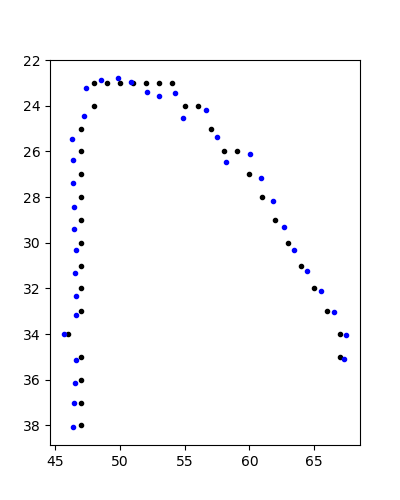

In [29]:
f, ax = plt.subplots(1, 1, figsize=(4, 5))
x = []
y = []
for v in new_apical_point_set:
    x.append(v.tail_x)
    y.append(v.tail_y)
ax.scatter(x, y, marker='.', color='b', zorder=2)
x = []
y = []
for v in previous_apical_point_set:
    x.append(v.tail_x)
    y.append(v.tail_y)
ax.scatter(x, y, marker='.', color='k', zorder=1)
ax.invert_yaxis()

## Ok, still not much change when you directly apply the warp information.

## How about instead look at the actualy values of the vector magnitudes at a single point to see if the values themselves are even that big ? 

In [30]:
x, y = 48, 23
x_deltas = []
y_deltas = []
for i in range(delta_ed_es):
    x_deltas.append(curr_clip_motions[0][i][y][x])
    y_deltas.append(curr_clip_motions[1][i][y][x])
x_deltas_sum = np.sum(x_deltas)
y_deltas_sum = np.sum(y_deltas)

In [31]:
x_deltas

[-0.021157773211598396,
 -0.02622188627719879,
 -0.04957382753491402,
 -0.06014641001820564,
 -0.06443661451339722,
 -0.06852827966213226,
 -0.06775704026222229,
 -0.06794138252735138,
 -0.049345556646585464,
 -0.03157989680767059,
 -0.025543808937072754,
 -0.024052904918789864,
 -0.03089233674108982,
 -0.032329071313142776,
 -0.03730304539203644,
 -0.040005072951316833]

In [32]:
y_deltas

[0.020763393491506577,
 0.012668684124946594,
 0.0006658657221123576,
 -0.004766413010656834,
 0.008009836077690125,
 0.006006302777677774,
 0.015485218726098537,
 0.01406671479344368,
 0.008431755937635899,
 0.012542186304926872,
 0.013791781850159168,
 0.018543368205428123,
 0.01710018701851368,
 0.01628810726106167,
 0.015564674511551857,
 0.015824107453227043]

In [33]:
x_deltas_sum, y_deltas_sum

(-0.6968149077147245, 0.19098577124532312)

## Ok, so the vector magnitudes themselves are not that big, what kind of difference should we expect?
## Let's at the point sets for a patient at the `ED` and `ES` frame from the auto segmentation

In [34]:
ed_points = image_to_whole_point_set(ed_one_hot_seg_out)

es_points = image_to_whole_point_set(one_hot(curr_clip_segmentations[:,delta_ed_es,...]))

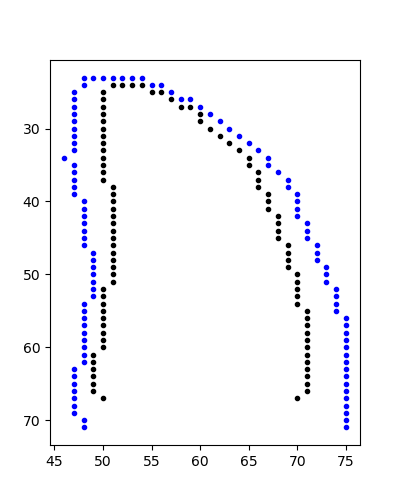

In [35]:
f, ax = plt.subplots(1, 1, figsize=(4, 5))
ax.scatter(ed_points[:, 0], ed_points[:, 1], marker='.', color='b', zorder=1)
ax.scatter(es_points[:, 0], es_points[:, 1], marker='.', color='k', zorder=2)
ax.invert_yaxis()

In [36]:
ed_points[0], es_points[0]

Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 1.75, 'type': 'set_device_pixel_ratio'}


(array([48, 23]), array([51, 24]))

There's no way to actually know if this first point is the same first point in frames `ED` and `ES`. But let's assume it is and see what kind of delta_x and delta_y we need.

In [37]:
es_points[0][0] - ed_points[0][0], es_points[0][1] - ed_points[0][1]

(3, 1)

Need <u>integer</u> values of deltas...in comparison, we have deltas in our motion tracking on the scale of 1e-2 for every frame, and only after you sum them up for delta_ed_es times you get on scale of 1e-1

## Show how one point/vector traverses from frame `ED` to frame `ES`

In [38]:
# one vector and show its progression thru time
# that means we'll need to keep all of the intermediate vectors of this single point being traversed thru time/frame

multiple_time_snapshots_of_vector_id_0 = []

vector_id_0 = apical_point_set[0]

v = vector_id_0 # (x_0, y_0, delta_x_0, delta_y_0)
v.mag_x = curr_clip_motions[0][0][v.tail_y][v.tail_x]
v.mag_y = curr_clip_motions[1][0][v.tail_y][v.tail_x]


multiple_time_snapshots_of_vector_id_0.append(v)



for frame in range(delta_ed_es):
    frame += 1
    
    new_vect = copy.deepcopy(multiple_time_snapshots_of_vector_id_0[-1])

    new_vect.update_tails_from_mags()
    
    new_vect.clear_magnitudes()
    new_vect.clear_conversion_mags_xy()
    new_vect.clear_conversion_mags_rhotheta()

    # now interpolate to get delta_x_1, delta_y_1
    # get surrounding vectors forming the unit square
    # v = copy.deepcopy(new_vect)
    inted_i, inted_j = int(new_vect.tail_y), int(new_vect.tail_x)
    surr_vec_tails = [ [inted_i, inted_j],
                       [inted_i, inted_j+1],
                       [inted_i+1, inted_j],
                       [inted_i+1, inted_j+1] ]

    surround_vectors = []

    for _ in surr_vec_tails:
        i,j = _[0], _[1]
        x = j
        y = i

        forward_x = curr_clip_motions[0][frame][i][j]
        forward_y = curr_clip_motions[1][frame][i][j]

        surround_vectors.append(Vector(x, y, forward_x, forward_y))

    # convert magnitudes into polar, bilinearly interpolate new vector magnitude in polar
    # to the input vector v's tail_x, tail_y, convert back into 
    # cartesian, apply the warp, clear out conversion value holders
    v_new = vector_bilinear_interpolation(vectors=surround_vectors, new_vector=new_vect)

    v_new.update_mag_xy_from_conversion()
    
    delta_x_1 = v_new.mag_x
    delta_y_1 = v_new.mag_y

    new_vect.mag_x = delta_x_1
    new_vect.mag_y = delta_y_1

    multiple_time_snapshots_of_vector_id_0.append(new_vect)
    # else:
    #     # all other frames i > 1
    #     new_vect.update_tails_from_mags()
    #     new_vect.mag_x = 0
    #     new_vect.mag_y = 0
    
    

# # we want to save vectors in a manner just for visualization, not for actual usage
# # (x_1, y_1, delta_x_1, delta_y_1)

# for i in range(delta_ed_es):
#     delta_x_0 = curr_clip_motions[0][i][v
#     delta_y_0 = 
    
#     v_next = warp_one_vector_forward_once(v, i, curr_clip_motions)

In [39]:
# last point does not need magnitude as that point should be the point in the ES frame
multiple_time_snapshots_of_vector_id_0[-1].clear_magnitudes()

In [40]:
len(multiple_time_snapshots_of_vector_id_0)

17

In [41]:
delta_ed_es

16

In [42]:
for v in multiple_time_snapshots_of_vector_id_0:
    print(v)

tail_x: 48
tail_y: 23
mag_x: -0.021157773211598396
mag_y: 0.020763393491506577

tail_x: 47.9788422267884
tail_y: 23.020763393491507
mag_x: -0.026359649722246924
mag_y: 0.013845380475934508

tail_x: 47.95248257706616
tail_y: 23.03460877396744
mag_x: -0.04915690876643638
mag_y: 0.004461736001547625

tail_x: 47.90332566829972
tail_y: 23.03907050996899
mag_x: -0.040813152867237364
mag_y: -0.04342614424395306

tail_x: 47.862512515432485
tail_y: 22.99564436572504
mag_x: -0.06512788807531317
mag_y: 0.012443508111507778

tail_x: 47.797384627357175
tail_y: 23.008087873836548
mag_x: -0.0695421696576263
mag_y: 0.01269216707019214

tail_x: 47.72784245769955
tail_y: 23.02078004090674
mag_x: -0.06444146213931436
mag_y: 0.02095478457551627

tail_x: 47.66340099556024
tail_y: 23.041734825482255
mag_x: -0.05752448691668763
mag_y: 0.01785752874365196

tail_x: 47.60587650864355
tail_y: 23.059592354225906
mag_x: -0.040495779316500426
mag_y: 0.01679673957566762

tail_x: 47.565380729327046
tail_y: 23.0763890

In [43]:
def vis_one_vec_multiple_frames(all_vectors):
    '''
    input: all_vectors - python list of Vector ADTs
    
    '''
    
    x_tails = []
    y_tails = []
    x_mags = []
    y_mags = []

    for v in all_vectors:
        x_tails.append(v.tail_x)
        y_tails.append(v.tail_y)

        x_mags.append(v.mag_x)
        y_mags.append(v.mag_y)

    # vector field
    f, ax = plt.subplots(1,2,figsize=(8, 5))
    ax[0].quiver(x_tails, y_tails, x_mags, y_mags, color='k', linewidth=0.7)
    ax[0].invert_yaxis()
    
    # scatter plot, color gradient points
    ax[1].scatter(x_tails, y_tails, c=np.linspace(0,1,len(x_tails)))
    ax[1].invert_yaxis()

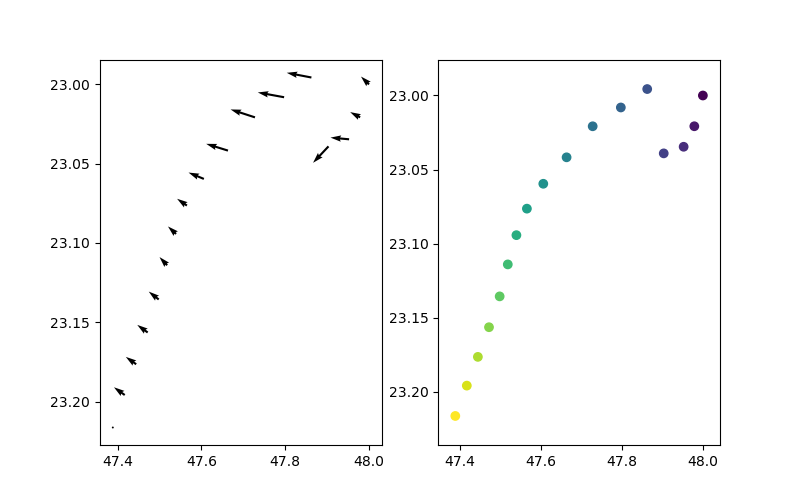

In [44]:
# print all the vectors
vis_one_vec_multiple_frames(multiple_time_snapshots_of_vector_id_0)

In [45]:
multiple_time_snapshots_of_vector_id_0

In [46]:
for v in multiple_time_snapshots_of_vector_id_0:
    print(v)

tail_x: 48
tail_y: 23
mag_x: -0.021157773211598396
mag_y: 0.020763393491506577

tail_x: 47.9788422267884
tail_y: 23.020763393491507
mag_x: -0.026359649722246924
mag_y: 0.013845380475934508

tail_x: 47.95248257706616
tail_y: 23.03460877396744
mag_x: -0.04915690876643638
mag_y: 0.004461736001547625

tail_x: 47.90332566829972
tail_y: 23.03907050996899
mag_x: -0.040813152867237364
mag_y: -0.04342614424395306

tail_x: 47.862512515432485
tail_y: 22.99564436572504
mag_x: -0.06512788807531317
mag_y: 0.012443508111507778

tail_x: 47.797384627357175
tail_y: 23.008087873836548
mag_x: -0.0695421696576263
mag_y: 0.01269216707019214

tail_x: 47.72784245769955
tail_y: 23.02078004090674
mag_x: -0.06444146213931436
mag_y: 0.02095478457551627

tail_x: 47.66340099556024
tail_y: 23.041734825482255
mag_x: -0.05752448691668763
mag_y: 0.01785752874365196

tail_x: 47.60587650864355
tail_y: 23.059592354225906
mag_x: -0.040495779316500426
mag_y: 0.01679673957566762

tail_x: 47.565380729327046
tail_y: 23.0763890

## Ok, let's just create the visualization of three regional point sets with ED and ES overlapping

In [47]:
I_ED_and_ES_regional_point_sets_as_vectors = {}
I_ED_and_ES_regional_point_sets_as_vectors['ED'] = []
I_ED_and_ES_regional_point_sets_as_vectors['ES'] = []


for IND in range(N):
    ps = I_regional_point_sets[IND]

    ps = convert_point_set_ij_into_xy(ps)

    ps = convert_point_set_xy_into_vectors(ps)

    new_ps = warp_one_point_set_forward_delta_times(ps_vectors = ps, 
                                           motion = curr_clip_motions,
                                           delta = delta_ed_es)

    I_ED_and_ES_regional_point_sets_as_vectors['ED'].append(ps)
    I_ED_and_ES_regional_point_sets_as_vectors['ES'].append(new_ps)

In [48]:
def vis_double_three_point_sets(vectors_dict, title='ED Blue | ES Red'):
    '''
    vectors_dict - two keys 'ED' and 'ES'
        each point to an array of three point sets representing regional points (apical, mid, basal) ... or more depending on N...well it's hardcoded for now
    '''
    fig, ax = plt.subplots(1,3, figsize=(10,7), sharex = True, sharey = True)
    x = []
    y = []
    for v in vectors_dict['ED'][0]:
        x.append(v.tail_x)
        y.append(v.tail_y)
    ax[0].scatter(x, y, marker='.', color='b', zorder=1)     # ED
    
    x.clear()
    y.clear()
    for v in vectors_dict['ES'][0]:
        x.append(v.tail_x)
        y.append(v.tail_y)
    ax[0].scatter(x, y, marker='.', color='r', zorder=2) # ES
    ax[0].invert_yaxis()
    ax[0].set_title('Apical')

    
    x.clear()
    y.clear()
    for v in vectors_dict['ED'][1]:
        x.append(v.tail_x)
        y.append(v.tail_y)
    ax[1].scatter(x, y, marker='.', color='b', zorder=1)    # ED
    
    x.clear()
    y.clear()
    for v in vectors_dict['ES'][1]:
        x.append(v.tail_x)
        y.append(v.tail_y)
    ax[1].scatter(x, y, marker='.', color='r', zorder=2)# ES
    ax[1].invert_yaxis()
    ax[1].set_title('Mid')

    
    x.clear()
    y.clear()
    for v in vectors_dict['ED'][2]:
        x.append(v.tail_x)
        y.append(v.tail_y)
    ax[2].scatter(x, y, marker='.', color='b', zorder=1)    # ED
    
    x.clear()
    y.clear()
    for v in vectors_dict['ES'][2]:
        x.append(v.tail_x)
        y.append(v.tail_y)
    ax[2].scatter(x, y, marker='.', color='r', zorder=2)# ES
    ax[2].invert_yaxis()
    ax[2].set_title('Basal')
    
    fig.suptitle(title)

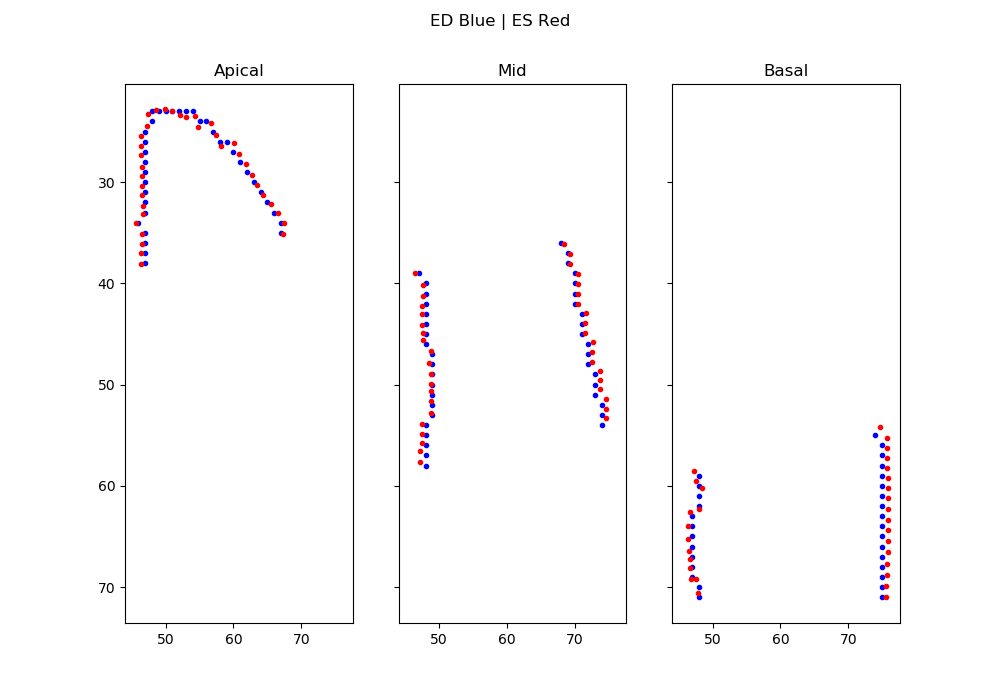

In [49]:
vis_double_three_point_sets(vectors_dict = I_ED_and_ES_regional_point_sets_as_vectors)

## Compare that using model's ED segmentation output with the point sets gotten directly from the Dataset labels

In [50]:
ground_truth_I_ED_and_ES_regional_point_sets_as_vectors = {}
ground_truth_I_ED_and_ES_regional_point_sets_as_vectors['ED'] = []
ground_truth_I_ED_and_ES_regional_point_sets_as_vectors['ES'] = []

ed_regional_point_sets = image_to_regional_point_sets(ed_label)
es_regional_point_sets = image_to_regional_point_sets(es_label)

for IND in range(N):
    ed_ps = ed_regional_point_sets[IND]
    ed_ps = convert_point_set_ij_into_xy(ed_ps)
    ed_ps = convert_point_set_xy_into_vectors(ed_ps)
    
    es_ps = es_regional_point_sets[IND]
    es_ps = convert_point_set_ij_into_xy(es_ps)
    es_ps = convert_point_set_xy_into_vectors(es_ps)

    
    ground_truth_I_ED_and_ES_regional_point_sets_as_vectors['ED'].append(ed_ps)
    ground_truth_I_ED_and_ES_regional_point_sets_as_vectors['ES'].append(es_ps)

/home/wang/workspace/JupyterNoteBooksAll/fully-automated-multi-heartbeat-echocardiography-video-segmentation-and-motion-tracking/src/strain.py:1156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  I_regional_point_sets = np.array(I_regional_point_sets)


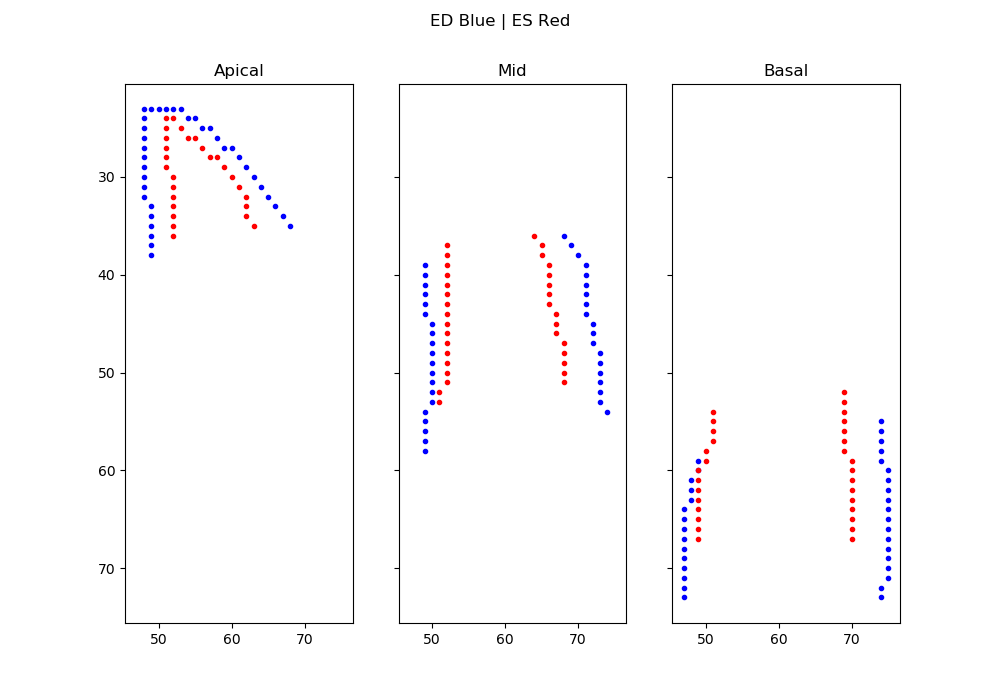

In [51]:
vis_double_three_point_sets(vectors_dict = ground_truth_I_ED_and_ES_regional_point_sets_as_vectors)

## Let's try scaling the magnitudes of the vectors and see if we get better movement? But I wouldn't think so??

In [52]:
I_ED_and_ES_regional_point_sets_as_vectors_1 = {}
I_ED_and_ES_regional_point_sets_as_vectors_1['ED'] = []
I_ED_and_ES_regional_point_sets_as_vectors_1['ES'] = []


for IND in range(N):
    ps = I_regional_point_sets[IND]

    ps = convert_point_set_ij_into_xy(ps)

    ps = convert_point_set_xy_into_vectors(ps)

    new_ps = warp_one_point_set_forward_delta_times(ps_vectors = ps, 
                                           motion = curr_clip_motions,
                                           delta = delta_ed_es,
                                           scale = -5.50)

    I_ED_and_ES_regional_point_sets_as_vectors_1['ED'].append(ps)
    I_ED_and_ES_regional_point_sets_as_vectors_1['ES'].append(new_ps)

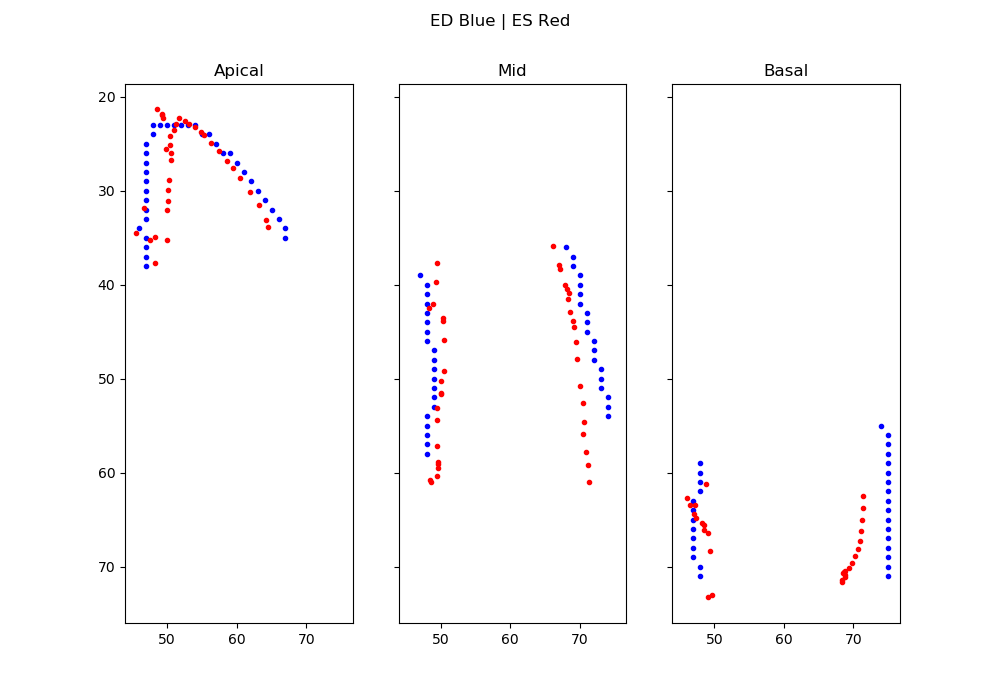

In [53]:
vis_double_three_point_sets(vectors_dict = I_ED_and_ES_regional_point_sets_as_vectors_1)